# Look at these Repos
https://github.com/TrainorLab/eeg-analysis-templates/blob/64eef6bc453517bd0ee117da9ab469f392e6211e/Analysis.ipynb

https://github.com/mne-tools/mne-tools.github.io/blob/acf6730a27814afaf984d1de0867ccd3abf4db1b/0.20/_downloads/ee17e3e8df43ce4f0119faeeeccc374f/plot_sensors_time_frequency.ipynb

https://github.com/mne-tools/mne-tools.github.io/blob/59d49be2769d80f25ba26c78caadd0ba4941345d/stable/_downloads/58e35821e0f211b843d5ead3e33d8849/20_sensors_time_frequency.ipynb

(Looking at Attention, Contra vs Ipsi with Alpha)
https://github.com/AGhaderi/hDDM_attention/blob/bfa2730e1763b7ee19771483c67f2109cf2674aa/eeg/Ipsilateral_Neutral.ipynb
- https://github.com/AGhaderi/hDDM_attention/blob/main/figures/Contra_Neut_imshow.pdf  (clean ERSP)
- https://github.com/AGhaderi/hDDM_attention/blob/main/figures/Contra_Neut_topography.pdf (8-13Hz, showing decrease on one side)
- https://github.com/AGhaderi/hDDM_attention/blob/main/figures/Corr_heatmap.pdf (Showing Correlation Stats, Matrix/Heatmap)

Try this on Tracking Phase
https://mne.tools/dev/auto_examples/time_frequency/source_label_time_frequency.html

Take des 0.5s window and classify Phase.
http://predictablynoisy.com/mne-python/auto_tutorials/plot_stats_cluster_time_frequency.html#sphx-glr-auto-tutorials-plot-stats-cluster-time-frequency-py

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pickle
import copy

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf, concatenate_raws
from mne.time_frequency import tfr_morlet

import collections
from autoreject import AutoReject

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/NeuroTracker/')
from cda_utils import get_epochs, get_CDA, prep_report, fill_report, get_report, checksum, add_cda_report, get_CDA_perf_report
#from events import get_specific_events

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
trigger = 2

# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
# 

# T2 = T1 + 5s 
# T4 = T2 + 2s
# T8 = T4 + 9s ?! (9s ?)
# T16 = T8 + ~1s
# T32 = T8 + 25s   ensuite un autre 3s plus tard.

# Beaucoup de 1 et 32.. pas clair...

# --------------------------
conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

#report = prep_report(conds, sides, perfs)

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]

# CDA Channels
chan_right_all = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P6', 'P8', 'P10', 'C2', 'C4', 'C6', 'CP2', 'CP4', 'CP6', 'T8', 'TP8', 'FT8', 'FC2', 'FC4', 'FC6', 'F2', 'F4', 'F6', 'F8', 'AF4', 'AF8', 'Fp2']
chan_left_all =  ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P5', 'P7', 'P9',  'C1', 'C3', 'C5', 'CP1', 'CP3', 'CP5', 'T7', 'TP7', 'FT7', 'FC1', 'FC3', 'FC5', 'F1', 'F3', 'F5', 'F7', 'AF3', 'AF7', 'Fp1']
chan_midline_all = ['Fz', 'FCz', 'Cz', 'Fpz', 'CPz', 'Pz', 'POz', 'Oz'] #'Iz'

clusters = ['F', 'P', 'C', 'O', 'T']
clusters_names = {'F':'Frontal', 'P':'Parietal', 'C':'Central', 'O':'Occipital', 'T':'Temporal'}


# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.6)

# Epochs variable!
preproc_dict_all = dict()
events_dict_all = dict()
epochs_dict_all = dict()
rt_dict_all = dict()

cda_cluster_all = dict()



In [250]:
#raw = read_raw_bdf("/Volumes/Cortex/PhD/Open Datasets/Data/AP140119.bdf", preload=True)
raw = read_raw_bdf("/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/T23F1.bdf", preload=True)

raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Sampling Frequency
sfreq = raw.info['sfreq']

# Events 
events = find_events(raw)

#Max Events in File...
#---------------------------
#32: 88
#1:  172
#2:  84
#4:  84
#8:  84
#16: 4
#---------------------------

# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD
# 32 - TBD (juste juste avant le 1, so I guess fin de trial)

Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/T23F1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6590463  =      0.000 ...  3218.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
516 events found
Event IDs: [ 1  2  4  8 16 32]


In [251]:
total = 0
frequency = collections.Counter(events[:,2])
events_frequency = dict(frequency)

print('Max Events in File...')
print("---------------------------")
for e in set(events[:,2]):
    print("{}: \t\t{}".format(e, frequency[e]))
print("---------------------------")

Max Events in File...
---------------------------
32: 		88
1: 		172
2: 		84
4: 		84
8: 		84
16: 		4
---------------------------


Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -6.02 dB



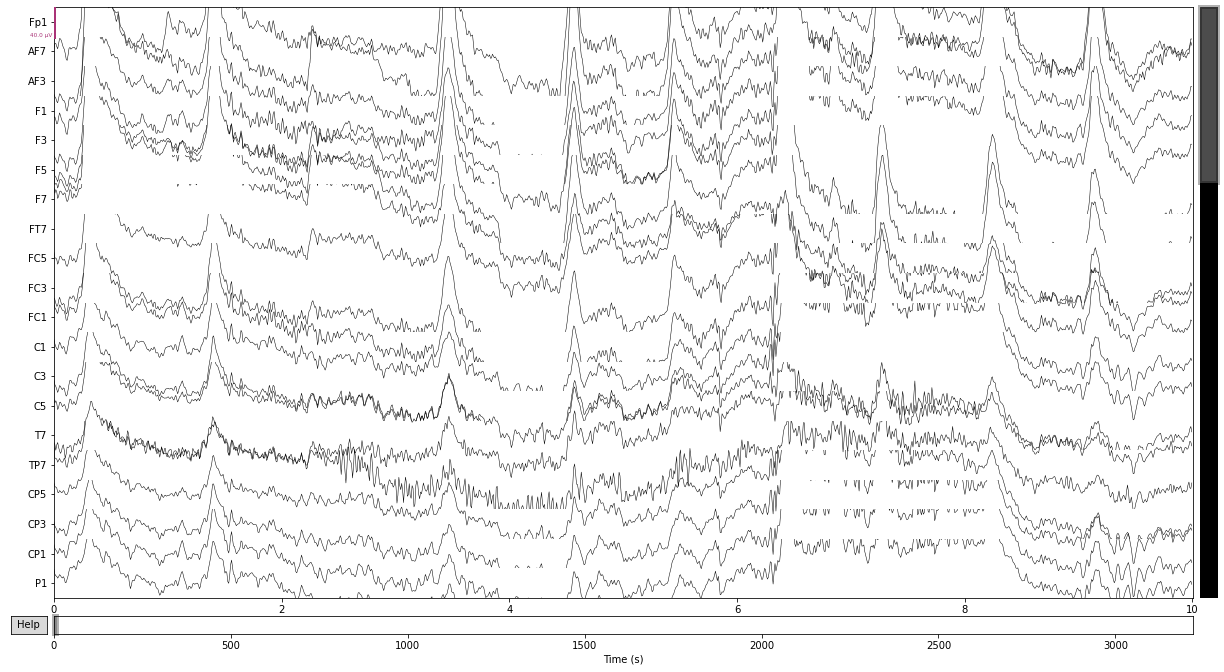

In [252]:
x = raw.plot(events=events, block=True, lowpass=40)

In [253]:
df_behav = pd.read_csv('/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/T23F1.csv', sep=',')
df_behav

#Trial  Synch  NbTargets  NbDistractors  Speed        Mode  Wallsize  \
0        1   True          3              5    0.6        Left        10   
1        2  False          1              7    0.6        Left        10   
2        3  False          1              7    0.6  ClassicMod        10   
3        4  False          2              6    0.6        Left        10   
4        5  False          2              6    0.6       Right        10   
..     ...    ...        ...            ...    ...         ...       ...   
79      17  False          3              5    0.5       Right        10   
80      18  False          1              7    0.5        Left        10   
81      19  False          1              7    0.5       Right        10   
82      20   True          2              6    0.5        Left        10   
83      21  False          3              5    0.5  ClassicMod        10   

    Results  [TID_Entered_1]  [TID_Entered_2]  ...  MiddleTimeCross.3  \
0         0                1                2  ...                 --   
1         1                8                0  ...                 --   
2         1                2                0  ...                 --   
3         1                7                5  ...                 --   
4         2                6                8  ...                 --   
..      ...              ...              ...  ...                ...   
79        3                2                5  ...                 --   
80        1                4                0  ...                 --   
81        1                4                0  ...                 --   
82        2                8                2  ...                 --   
83        3                6                8  ...                 --   

    Ball Id.4  TimeCross  Ball Id.5  TimeCross.1  Ball Id.6  TimeCross.2  \
0          --         --         --           --         --           --   
1          --         --         --           --         --           --   
2          --         --         --           --         --           --   
3          --         --         --           --         --           --   
4          --         --         --           --         --           --   
..        ...        ...        ...          ...        ...          ...   
79         --         --         --           --         --           --   
80         --         --         --           --         --           --   
81         --         --         --           --         --           --   
82         --         --         --           --         --           --   
83         --         --         --           --         --           --   

    Ball Id.7  TimeCross.3  Unnamed: 36  
0          --           --          NaN  
1          --           --          NaN  
2          --           --          NaN  
3          --           --          NaN  
4          --           --          NaN  
..        ...          ...          ...  
79         --           --          NaN  
80         --           --          NaN  
81         --           --          NaN  
82         --           --          NaN  
83         --           --          NaN  

[84 rows x 37 columns]

In [254]:
new_events = []
nb_trials = 0
total_skipped = 0
for e in events:
    cur_cond = None
    cur_side = None
    cur_perf = None
    if e[2] == 2: # Find Start of Trial
        cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
        cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
        cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
        if cur_cond is not None and cur_side is not None and cur_perf is not None:
            #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
            temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
            new_events.append(temp_event) # Make a new list of events with new custom triggers.
        else:
            total_skipped = total_skipped + 1
            print('Skipping this event {}: No Cond or Side or Perf'.format(e))

        nb_trials = nb_trials + 1
        
# Calculate average response time.
resp_time_in_ticks = []
for i, e in enumerate(events):
    if e[2] == 8:
        if events[i+1,2] == 32:
            resp_time_in_ticks.append(events[i+1,0] - events[i,0])
        elif events[i+1,2] == 16: #Synch?!
            if events[i+2,2] == 32:
                resp_time_in_ticks.append(events[i+2,0] - events[i,0])
            else:
                print('No Response?! Trigger: {}'.format(events[i+1,2]))
        else:
            print('No Response?! Trigger: {}'.format(events[i+1,2]))

mean_rt = np.mean(resp_time_in_ticks)
std_rt = np.std(resp_time_in_ticks)
print('Response Time ~{:.2f}s (std:{:.2f})'.format(mean_rt/sfreq, std_rt/sfreq))

print("A total of {} trials were added and {} were skipped.".format(nb_trials, total_skipped))

Response Time ~7.37s (std:4.70)
A total of 84 trials were added and 0 were skipped.


In [255]:
tmin = -3
tmax = 20
baseline_corr = (-2.5, -2)

print('==================================================')
print('REMOVING EVENTS ID NOT IN EEG FILE...')
cur_event_id = copy.deepcopy(event_id)
newevents_in_file = set(np.array(new_events)[:,2])
keys_to_delete = []
for e in cur_event_id.keys():
    if event_id[e] not in newevents_in_file:
        print('Event: {} ({}), not present.'.format(e, event_id[e]))
        keys_to_delete.append(e)
for key in keys_to_delete:
    del cur_event_id[key]
print('==================================================')  

epochs = Epochs(raw, new_events, event_id=cur_event_id, tmin=tmin, tmax=tmax, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')

epochs

REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


<Epochs |  84 events (all good), -3 - 20 sec, baseline -2.5 – -2 sec, ~1.98 GB, data loaded,
 '1/classicmod/bad': 2
 '1/classicmod/good': 6
 '1/left/good': 10
 '1/right/bad': 1
 '1/right/good': 9
 '2/classicmod/bad': 3
 '2/classicmod/good': 5
 '2/left/bad': 2
 '2/left/good': 8
 '2/right/bad': 3
 '2/right/good': 7
 '3/classicmod/bad': 4
 '3/classicmod/good': 4
 '3/left/bad': 7
 '3/left/good': 3
 '3/right/bad': 7
 '3/right/good': 3>

Need more than one channel to make topography for eeg. Disabling interactivity.


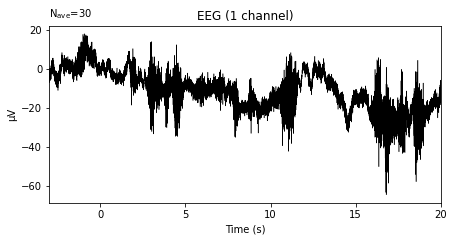

Need more than one channel to make topography for eeg. Disabling interactivity.


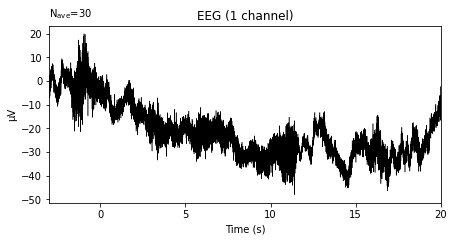

In [256]:
epochs_right = epochs['right'].pick_channels(['T8'])
epochs_left = epochs['right'].pick_channels(['T7'])

evoked_right = epochs_right.average().plot() #.data
evoked_left = epochs_left.average().plot() #.data

#cda = evoked_right - evoked_left

#plt.plot(times, cda)

Running autoreject on ch_type=eeg


100%|█████████████████████████████████| Creating augmented epochs : 64/64 [00:46<00:00,    1.38it/s]
100%|██████████████████████████████████| Computing thresholds ... : 64/64 [13:01<00:00,   12.21s/it]


  0%|                                               | Repairing epochs : 0/84 [00:00<?,       ?it/s]

  4%|█▌                                         | Repairing epochs : 3/84 [00:00<00:00,  177.31it/s]

  7%|███                                        | Repairing epochs : 6/84 [00:00<00:00,  161.20it/s]

 11%|████▌                                      | Repairing epochs : 9/84 [00:00<00:00,  157.93it/s]

 14%|██████                                    | Repairing epochs : 12/84 [00:00<00:00,  160.73it/s]

 18%|███████▌                                  | Repairing epochs : 15/84 [00:00<00:00,  161.64it/s]

 21%|█████████                                 | Repairing epochs : 18/84 [00:00<00:00,  161.24it/s]

 25%|██████████▌                               | Repairing epochs : 21/84 [00:00<0

 52%|██████████████████████                    | Repairing epochs : 44/84 [00:01<00:00,   46.14it/s]

 54%|██████████████████████▌                   | Repairing epochs : 45/84 [00:01<00:00,   46.35it/s]

 55%|███████████████████████                   | Repairing epochs : 46/84 [00:01<00:00,   46.41it/s]

 56%|███████████████████████▌                  | Repairing epochs : 47/84 [00:01<00:00,   46.82it/s]

 57%|████████████████████████                  | Repairing epochs : 48/84 [00:01<00:00,   46.46it/s]

 58%|████████████████████████▌                 | Repairing epochs : 49/84 [00:01<00:00,   46.91it/s]

 60%|█████████████████████████                 | Repairing epochs : 50/84 [00:01<00:00,   47.37it/s]

 61%|█████████████████████████▍                | Repairing epochs : 51/84 [00:01<00:00,   47.47it/s]

 62%|██████████████████████████                | Repairing epochs : 52/84 [00:01<00:00,   47.31it/s]

 63%|██████████████████████████▌               | Repairing epochs : 53/84 [00:01<0

  0%|                                               | Repairing epochs : 0/84 [00:00<?,       ?it/s]

  1%|▌                                          | Repairing epochs : 1/84 [00:00<00:01,   55.56it/s]

  2%|█                                          | Repairing epochs : 2/84 [00:00<00:01,   51.64it/s]

  4%|█▌                                         | Repairing epochs : 3/84 [00:00<00:01,   47.39it/s]

  5%|██                                         | Repairing epochs : 4/84 [00:00<00:01,   47.53it/s]

  6%|██▌                                        | Repairing epochs : 5/84 [00:00<00:01,   46.13it/s]

  7%|███                                        | Repairing epochs : 6/84 [00:00<00:01,   45.43it/s]

  8%|███▌                                       | Repairing epochs : 7/84 [00:00<00:01,   45.31it/s]

 10%|████                                       | Repairing epochs : 8/84 [00:00<00:01,   45.66it/s]

 11%|████▌                                      | Repairing epochs : 9/84 [00:00<0





Estimated consensus=0.70 and n_interpolate=32




  0%|                                               | Repairing epochs : 0/84 [00:00<?,       ?it/s]

  1%|▌                                          | Repairing epochs : 1/84 [00:00<00:01,   57.32it/s]

  2%|█                                          | Repairing epochs : 2/84 [00:00<00:01,   53.14it/s]

  4%|█▌                                         | Repairing epochs : 3/84 [00:00<00:01,   47.75it/s]

  5%|██                                         | Repairing epochs : 4/84 [00:00<00:01,   46.04it/s]

  6%|██▌                                        | Repairing epochs : 5/84 [00:00<00:01,   46.27it/s]

  7%|███                                        | Repairing epochs : 6/84 [00:00<00:01,   46.57it/s]

  8%|███▌                                       | Repairing epochs : 7/84 [00:00<00:01,   46.00it/s]

 10%|████                                       | Repairing epochs : 8/84 [00:00<00:01,   44.33it/s]

 11%|████▌                                      | Repairing epochs : 9/84 [00:00

Dropped 4 epochs: 36, 56, 59, 64


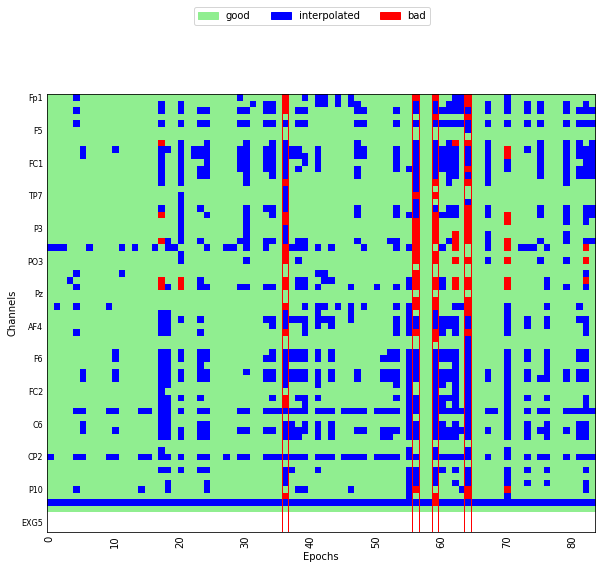

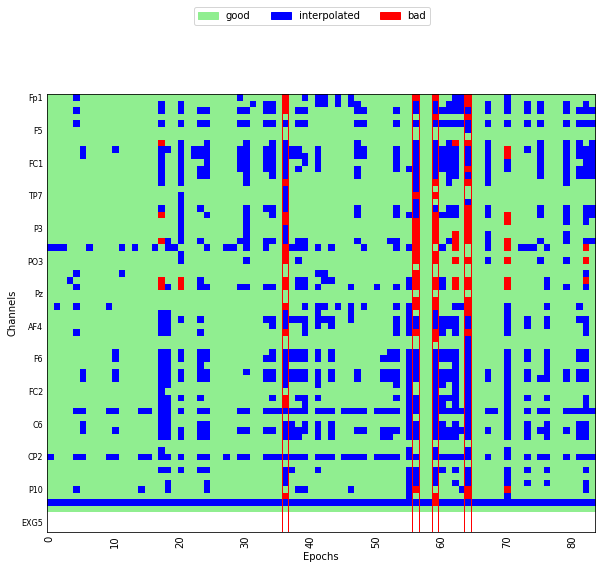

In [257]:
ar = AutoReject()
epochs_clean, reject_log = ar.fit_transform(epochs, return_log=True) 
fig, ax = plt.subplots(figsize=(15,8))
reject_log.plot('horizontal', ax=ax)

Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


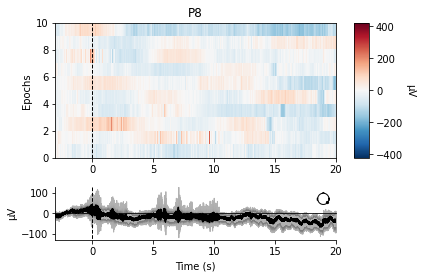

Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


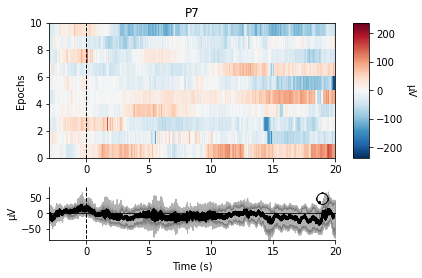

Not setting metadata
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


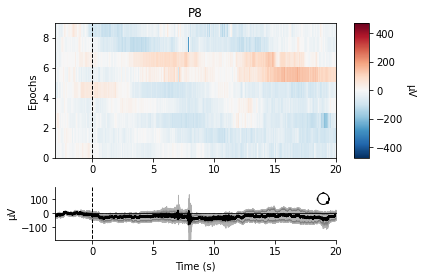

Not setting metadata
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


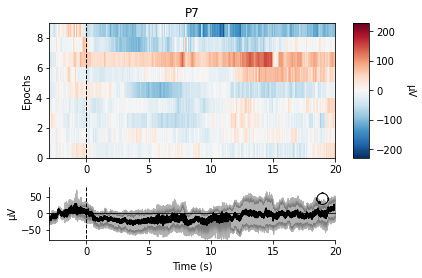

[<Figure size 432x288 with 4 Axes>]

In [263]:
epochs_clean['3/left'].plot_image(picks=['P8'])
epochs_clean['3/left'].plot_image(picks=['P7'])

epochs_clean['3/right'].plot_image(picks=['P8'])
epochs_clean['3/right'].plot_image(picks=['P7'])

In [278]:
epochs_freq = epochs_clean.copy().crop(tmin=0, tmax=15)#.pick_channels(['P7', 'P8', 'P3','C3', 'C4'])

freqs = np.logspace(*np.log10([20, 100]), num=20)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs_freq, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

#power.plot(baseline=(-0.2,0), vmin=-2e7)
## Times and baseline periods for QS/TR
# TR_times = {"tmin":-2., "tmax":1.}
# TR_baseline = (0., 1.)
#TR_power.plot([11], baseline=TR_baseline, mode='ratio', dB=True, vmin=-5., vmax=5., axes=axes[0, 0], show=False, colorbar=False, **TR_tim

<AxesSubplot:>

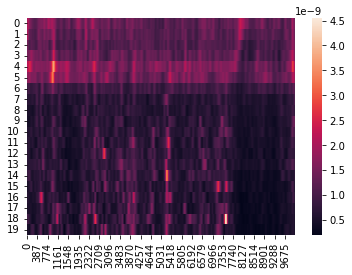

In [283]:
ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='AF3']
freq_anal = power.data[ch_id[0], :, :]
freq_anal.shape
sns.heatmap(freq_anal[:,100:-100])

<AxesSubplot:>

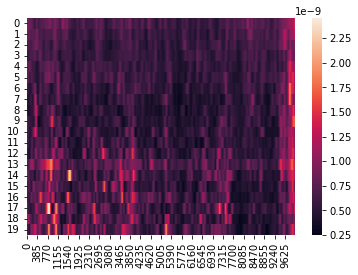

In [284]:
ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='P3']
freq_anal = power.data[ch_id[0], :, :]
freq_anal.shape
sns.heatmap(freq_anal[:,150:-100])

<AxesSubplot:>

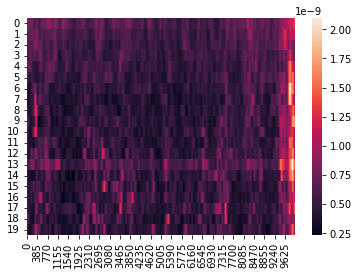

In [285]:
ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='P7']
freq_anal = power.data[ch_id[0], :, :]
freq_anal.shape
sns.heatmap(freq_anal[:,150:-100])

<AxesSubplot:>

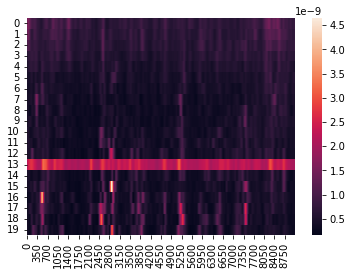

In [286]:
ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='PO8']
freq_anal = power.data[ch_id[0], :, :]
freq_anal.shape
sns.heatmap(freq_anal[:,150:-1000])

In [235]:
from mne.time_frequency import tfr_morlet

epochs_freq = epochs_clean.copy().crop(tmin=0, tmax=20)#.pick_channels(['P7', 'P8', 'P3','C3', 'C4'])

freqs = np.logspace(*np.log10([20, 200]), num=50)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs_freq['right'], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

<AxesSubplot:>

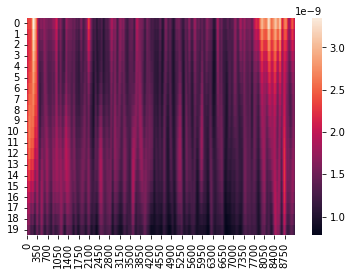

In [273]:
ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='P7']
freq_anal = power.data[ch_id[0], :, :]
freq_anal.shape
sns.heatmap(freq_anal[:,150:-1000])

<AxesSubplot:>

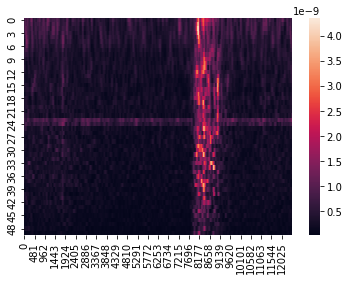

In [234]:
ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='P8']
freq_anal = power.data[ch_id[0], :, :]
freq_anal.shape
sns.heatmap(freq_anal[:,150:-1000])

In [208]:
dfp = power.to_data_frame(index='freq')
dfp

time           Fp1           AF7           AF3            F1  \
freq                                                                   
20.0       0  3.558745e-08  1.239696e-08  1.171220e-08  4.347115e-09   
20.0       1  3.560516e-08  1.241275e-08  1.173008e-08  4.361055e-09   
20.0       3  3.559938e-08  1.242056e-08  1.174047e-08  4.372495e-09   
20.0       4  3.557014e-08  1.242040e-08  1.174337e-08  4.381431e-09   
20.0       6  3.551754e-08  1.241227e-08  1.173880e-08  4.387865e-09   
...      ...           ...           ...           ...           ...   
150.0  19994  8.088932e-10  4.627578e-10  5.761380e-10  1.423179e-10   
150.0  19995  8.085369e-10  4.608290e-10  5.750497e-10  1.417272e-10   
150.0  19997  8.076978e-10  4.586725e-10  5.736431e-10  1.410682e-10   
150.0  19998  8.063831e-10  4.562931e-10  5.719229e-10  1.403424e-10   
150.0  20000  8.045963e-10  4.536943e-10  5.698923e-10  1.395507e-10   

                 F3            F5            F7           FT7           FC5  \
freq                                                                          
20.0   4.626736e-09  3.791931e-09  3.973762e-09  2.217828e-09  4.462601e-09   
20.0   4.645963e-09  3.807574e-09  3.987787e-09  2.229687e-09  4.472058e-09   
20.0   4.662623e-09  3.821064e-09  3.999503e-09  2.240338e-09  4.478743e-09   
20.0   4.676707e-09  3.832390e-09  4.008900e-09  2.249769e-09  4.482654e-09   
20.0   4.688208e-09  3.841545e-09  4.015975e-09  2.257973e-09  4.483794e-09   
...             ...           ...           ...           ...           ...   
150.0  2.626978e-10  1.883488e-10  1.737899e-10  3.523283e-10  4.518595e-10   
150.0  2.613717e-10  1.859894e-10  1.717754e-10  3.499059e-10  4.500950e-10   
150.0  2.599231e-10  1.835896e-10  1.697218e-10  3.473513e-10  4.481121e-10   
150.0  2.583549e-10  1.811515e-10  1.676306e-10  3.446684e-10  4.459162e-10   
150.0  2.566695e-10  1.786768e-10  1.655032e-10  3.418602e-10  4.435110e-10   

       ...           CP4           CP2            P2            P4  \
freq   ...                                                           
20.0   ...  1.891101e-09  1.513873e-09  1.653050e-09  1.539803e-09   
20.0   ...  1.902110e-09  1.525624e-09  1.662732e-09  1.549872e-09   
20.0   ...  1.912216e-09  1.536756e-09  1.671643e-09  1.559252e-09   
20.0   ...  1.921418e-09  1.547265e-09  1.679782e-09  1.567942e-09   
20.0   ...  1.929713e-09  1.557149e-09  1.687149e-09  1.575942e-09   
...    ...           ...           ...           ...           ...   
150.0  ...  1.832519e-10  1.535180e-10  1.804454e-10  1.537146e-10   
150.0  ...  1.823213e-10  1.529112e-10  1.802138e-10  1.531449e-10   
150.0  ...  1.813036e-10  1.522240e-10  1.798832e-10  1.524987e-10   
150.0  ...  1.802013e-10  1.514583e-10  1.794553e-10  1.517777e-10   
150.0  ...  1.790161e-10  1.506156e-10  1.789313e-10  1.509833e-10   

                 P6            P8           P10           PO8           PO4  \
freq                                                                          
20.0   1.598811e-09  1.698637e-09  1.622863e-09  4.525077e-09  2.446248e-09   
20.0   1.608366e-09  1.709785e-09  1.637637e-09  4.528953e-09  2.453441e-09   
20.0   1.617154e-09  1.720134e-09  1.651736e-09  4.530031e-09  2.459319e-09   
20.0   1.625172e-09  1.729679e-09  1.665147e-09  4.528325e-09  2.463889e-09   
20.0   1.632419e-09  1.738413e-09  1.677863e-09  4.523855e-09  2.467160e-09   
...             ...           ...           ...           ...           ...   
150.0  3.418974e-10  3.397294e-10  9.913782e-10  2.007279e-10  1.582427e-10   
150.0  3.412963e-10  3.386812e-10  9.731575e-10  1.998296e-10  1.573976e-10   
150.0  3.405000e-10  3.374562e-10  9.548836e-10  1.988305e-10  1.564764e-10   
150.0  3.395127e-10  3.360581e-10  9.365710e-10  1.977331e-10  1.554814e-10   
150.0  3.383371e-10  3.344894e-10  9.182329e-10  1.965392e-10  1.544144e-10   

                 O2  
freq                 
20.0   2.678882e-09  
20.0   2.685992e-09  
20.0   2.691645e

In [188]:
subdfp = dfp[['P4']]
subdfp

P4
freq               
1.0    1.435404e-07
1.0    1.432588e-07
1.0    1.428801e-07
1.0    1.424053e-07
1.0    1.418356e-07
...             ...
100.0  3.634664e-10
100.0  3.623672e-10
100.0  3.610880e-10
100.0  3.596301e-10
100.0  3.579942e-10

[682700 rows x 1 columns]

In [189]:
sns.heatmap(subdfp)

<AxesSubplot:ylabel='freq'>

No baseline correction applied


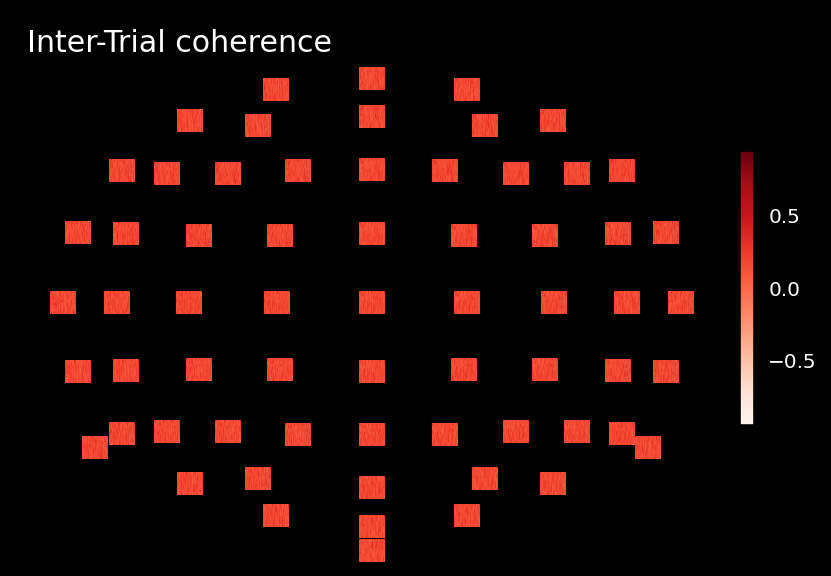

In [145]:
itc.plot_topo(title='Inter-Trial coherence', cmap='Reds')

In [91]:
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = [-1, 0]  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test


tfr = tfr_multitaper(epochs_clean, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in ['left', 'right']:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 7, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle(f"ERDS ({event})")
    plt.show()

Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.745884
stat_fun(H1): min=-7.267122 max=8.247667
Running initial clustering
Found 10 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  191.78it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  219.99it/s]


Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.745884
stat_fun(H1): min=-7.267122 max=8.247667
Running initial clustering
Found 5 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  196.10it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.745884


stat_fun(H1): min=-7.274245 max=6.358479
Running initial clustering
Found 11 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  201.51it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  221.53it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.745884
stat_fun(H1): min=-7.274245 max=6.358479
Running initial clustering
Found 5 clusters
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  198.68it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


Using a threshold of 1.745884
stat_fun(H1): min=-6.406765 max=7.470145
Running initial clustering
Found 9 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  199.38it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  215.89it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.745884
stat_fun(H1): min=-6.406765 max=7.470145
Running initial clustering
Found 3 clusters
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  197.47it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


Using a threshold of 1.745884
stat_fun(H1): min=-6.355428 max=5.663906
Running initial clustering
Found 7 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  197.43it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  217.56it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.745884
stat_fun(H1): min=-6.355428 max=5.663906
Running initial clustering
Found 5 clusters
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  197.14it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


Using a threshold of 1.745884
stat_fun(H1): min=-6.534207 max=7.176099
Running initial clustering
Found 14 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  182.80it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  212.38it/s]


Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.745884
stat_fun(H1): min=-6.534207 max=7.176099
Running initial clustering
Found 8 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  191.02it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


Using a threshold of 1.745884
stat_fun(H1): min=-5.831711 max=6.852460
Running initial clustering
Found 16 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  197.49it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  215.28it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.745884
stat_fun(H1): min=-5.831711 max=6.852460
Running initial clustering
Found 1 clusters


Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  198.12it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


Using a threshold of 1.739607
stat_fun(H1): min=-5.705573 max=6.786253
Running initial clustering
Found 10 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  191.88it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  206.84it/s]


Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.739607
stat_fun(H1): min=-5.705573 max=6.786253
Running initial clustering
Found 4 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  190.33it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.739607
stat_fun(H1): min=-6.559725 max=6.409074
Running initial clustering
Found 6 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  193.67it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  209.20it/s]


Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.739607
stat_fun(H1): min=-6.559725 max=6.409074
Running initial clustering
Found 10 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  190.04it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.739607
stat_fun(H1): min=-5.935283 max=6.235349
Running initial clustering
Found 14 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  194.01it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  202.99it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.739607


stat_fun(H1): min=-5.935283 max=6.235349
Running initial clustering
Found 6 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  191.40it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.739607
stat_fun(H1): min=-7.079705 max=7.858295
Running initial clustering
Found 14 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  186.07it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  198.47it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.739607
stat_fun(H1): min=-7.079705 max=7.858295
Running initial clustering


Found 6 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  181.61it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


Using a threshold of 1.739607
stat_fun(H1): min=-6.348500 max=7.067552
Running initial clustering
Found 8 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  182.28it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  202.57it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.739607
stat_fun(H1): min=-6.348500 max=7.067552
Running initial clustering
Found 10 clusters


Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  178.05it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.739607
stat_fun(H1): min=-8.314610 max=6.649338
Running initial clustering
Found 5 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  183.16it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  206.27it/s]


Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.739607
stat_fun(H1): min=-8.314610 max=6.649338
Running initial clustering
Found 3 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  185.67it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


In [85]:
epochs_clean.info.ch_names

['C3', 'T7', 'P7', 'C4', 'T8', 'P8']

In [ ]:
#https://natmeg.se/learnaboutmeg/meg%20skills/e.%20data%20analysis/e.2%20time-frequency%20analysis/time-frequency%20analysis%20with%20mne.html



# Report Functions

In [14]:
def prep_report(conds, sides, perfs):
    columns = []
    columns.extend(conds)
    columns.extend(sides)
    columns.extend(perfs)

    for cond in conds:
        for side in sides:
            columns.append('{}-{}'.format(cond, side))
            for perf in perfs:
                columns.append('{}-{}-{}'.format(cond, side, perf))
                if '{}-{}'.format(cond, perf) not in columns:
                    columns.append('{}-{}'.format(cond, perf))
    
    columns.append('checksum')
    columns.append('notes')
    
    return pd.DataFrame(columns=columns)


def fill_report(report, filename, specific_events):
    cur_row = list()
    cur_row.extend([0] * (len(report.keys()) - 1)) # Excluding notes columns
    cur_row.extend([''])
    report = report.append(pd.DataFrame([cur_row], columns=report.columns, index=[filename]))
    
    # Looking for level 1: conditions
    for cond in specific_events.keys():
        if cond not in report.keys():
            raise ValueError('Event Key ({}) not in Report Columns.'.format(k))
        
        for side in specific_events[cond].keys():
            if side not in report.keys():
                raise ValueError('Event Key ({}) not in Report Columns.'.format(k))
            
            for perf in specific_events[cond][side].keys():
                if perf not in report.keys():
                    raise ValueError('Event Key ({}) not in Report Columns.'.format(k))
                
                #print("Adding: {}-{}-{} ({}) to: {}".format(cond, side, perf, len(specific_events[cond][side][perf]), cond))
                report.at[filename, cond] = report.at[filename, cond] + len(specific_events[cond][side][perf])
                report.at[filename, side] = report.at[filename, side] + len(specific_events[cond][side][perf])
                report.at[filename, perf] = report.at[filename, perf] + len(specific_events[cond][side][perf])
                report.at[filename, '{}-{}'.format(cond, side)] = report.at[filename, '{}-{}'.format(cond, side)] + len(specific_events[cond][side][perf])
                report.at[filename, '{}-{}'.format(cond, perf)] = report.at[filename, '{}-{}'.format(cond, perf)] + len(specific_events[cond][side][perf])
                report.at[filename, '{}-{}-{}'.format(cond, side, perf)] = report.at[filename, '{}-{}-{}'.format(cond, side, perf)] + len(specific_events[cond][side][perf])
    
    return report


def get_report(report, conds, sides, perfs, other_cols):
    sub_report_cols = []
    for cond in conds: sub_report_cols.append(cond)
    for side in sides: sub_report_cols.append(side)
    for perf in perfs: sub_report_cols.append(perf)
    
    for cond in conds: 
        for side in sides: 
            sub_report_cols.append('{}-{}'.format(cond,side))
        
    for cond in conds: 
        for side in sides: 
            for perf in perfs: 
                sub_report_cols.append('{}-{}-{}'.format(cond, side, perf))
    
    return report[sub_report_cols]

# Quick and Dirty All Subjects Recall HF Look out.

In [3]:
#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
directory_path = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/'

#filepath = directory_path + 'M22F2.bdf'
for filepath in glob.iglob(directory_path + '*.bdf'):
    filename = filepath[filepath.rfind('/')+1:]
    
    # Skipping Exceptions with multiple EEG files. (they will be loaded with Block 1 (B1))
    if filename in ['M8M1_B3.bdf','M8M1_B4.bdf','M8M2_B3.bdf','M8M2_B4.bdf','T9F2_B3-B4.bdf','T9M1_B3-B4.bdf']:
        continue
    
    print('Processing: ' + filename + '...')

    # 1. -- Load File --
    if filename not in ['M8M1_B1-B2.bdf', 'M8M2_B1-B2.bdf', 'T9F2_B1-B2.bdf', 'T9M1_B1-B2.bdf']: # Check for exceptions with multiple EEG files.
        raw = read_raw_bdf(filepath, preload=True)
    else:
        if filename == 'M8M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'M8M1_B3.bdf', preload=True)
            raw3 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'M8M1_B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M1.bdf'
        if filename == 'M8M2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'M8M2_B3.bdf', preload=True)
            raw3 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'M8M2_B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M2.bdf'
        if filename == 'T9F2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'T9F2_B3-B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9F2.bdf'
        if filename == 'T9M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'T9M1_B3-B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9M1.bdf'            
    
    # 2. -- General Preprocess --
    # Keep only EEG channels and reference
    raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
    raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
    raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

    # Set Electrodes Locations
    montage = mne.channels.make_standard_montage('biosemi64')
    raw.set_montage(montage)

    # Resample
    sfreq = raw.info['sfreq']
    #sfreq = 256
    #preproc = raw.resample(sfreq)
    preproc = raw
    
    # Filter
    #preproc = preproc.filter(1, 30, fir_design='firwin', skip_by_annotation='edge')

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    events = find_events(preproc)
    
    # ---------- Debug Logs ----------
    frequency = collections.Counter(events[:,2])
    events_frequency = dict(frequency)
    print('Max Events in File...')
    print("---------------------------")
    for e in set(events[:,2]):
        print("{}: \t\t{}".format(e, frequency[e]))
    print("---------------------------")
    # ---------- Debug Logs ----------

    df_behav = pd.read_csv(directory_path + filename[:filename.rfind('.')] + '.csv', sep=',')

    new_events = []
    nb_trials = 0
    total_skipped = 0
    for e in events:
        cur_cond = None
        cur_side = None
        cur_perf = None
        if e[2] == 2: # Find Start of Trial
            cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
            cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
            cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
            if cur_cond is not None and cur_side is not None and cur_perf is not None:
                #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
                temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
                new_events.append(temp_event) # Make a new list of events with new custom triggers.
            else:
                total_skipped = total_skipped + 1
                print('Skipping this event {}: No Cond or Side or Perf'.format(e))

            nb_trials = nb_trials + 1

            # Check Synch!
            if (nb_trials + 1) % 10 == 0:
                print('Check Synch!')

    # Calculate average response time.
    resp_time_in_ticks = []
    for i, e in enumerate(events):
        if e[2] == 8:
            if events[i+1,2] == 32:
                resp_time_in_ticks.append(events[i+1,0] - events[i,0])
            elif events[i+1,2] == 16: #Synch?!
                if events[i+2,2] == 32:
                    resp_time_in_ticks.append(events[i+2,0] - events[i,0])
                else:
                    print('No Response?! Trigger: {}'.format(events[i+1,2]))
            else:
                print('No Response?! Trigger: {}'.format(events[i+1,2]))

    mean_rt = np.mean(resp_time_in_ticks)
    std_rt = np.std(resp_time_in_ticks)
    print('Response Time ~{:.2f}s (std:{:.2f})'.format(mean_rt/sfreq, std_rt/sfreq))
    
    print("A total of {} trials were added and {} were skipped.".format(nb_trials, total_skipped))

    preproc_dict_all[filename] = preproc
    events_dict_all[filename] = new_events
    rt_dict_all[filename] = (mean_rt, std_rt)
    
# Save All Subjects' Data
data_pickle = dict()
data_pickle['preproc'] = preproc_dict_all
data_pickle['events'] = events_dict_all

with open("AllSubs-Raw.pkl","wb") as f:
    pickle.dump(data_pickle, f)

Processing: M8M1_B1-B2.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/M8M1_B1-B2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4220927  =      0.000 ...  2061.000 secs...
Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/M8M1_B3.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3491839  =      0.000 ...  1705.000 secs...
Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/M8M1_B4.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535999  =      0.000 ...   750.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginn

BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5986303  =      0.000 ...  2923.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Max Events in File...
---------------------------
32: 		88
1: 		172
2: 		84
4: 		84
8: 		84
16: 		4
---------------------------
Check Synch!
Check Synch!
Check Synch!
Check Synch!
Check Synch!
Check Synch!
Check Synch!
Check Synch!
Response Time ~3.97s (std:2.39)
A total of 84 trials were added and 0 were skipped.
Processing: T9F2_B1-B2.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/T9F2_B1-B2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3352575  =  

REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
105 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 105 events and 47105 original time points ...
0 bad epochs dropped


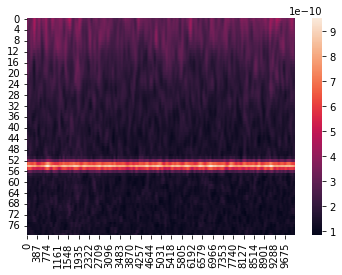

M8M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
75 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 75 events and 47105 original time points ...
0 bad epochs dropped


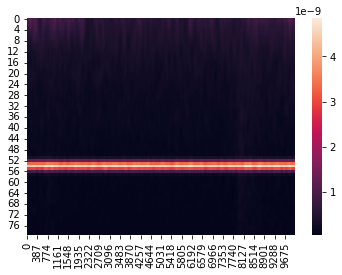

T16F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


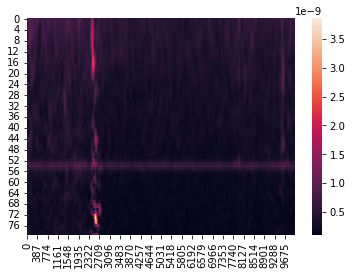

M22F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
83 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 83 events and 47105 original time points ...
0 bad epochs dropped


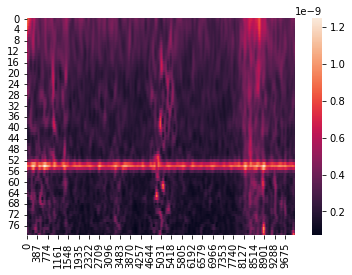

W17M2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


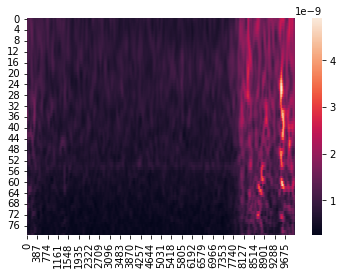

S20M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


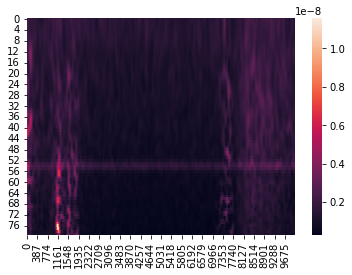

W10F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


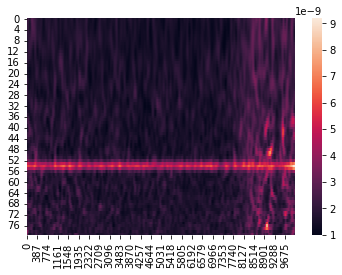

T11F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
94 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 94 events and 47105 original time points ...
0 bad epochs dropped


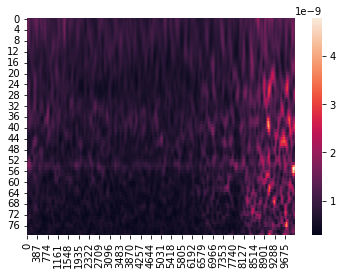

S21F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/left/bad (222), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


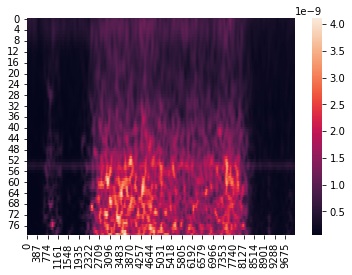

F19M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


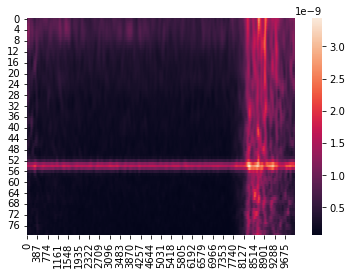

F12F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


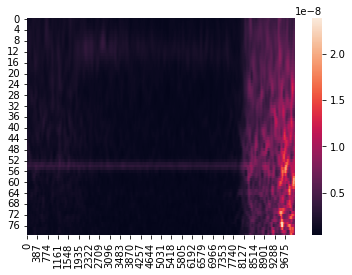

T9F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/right/bad (212), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


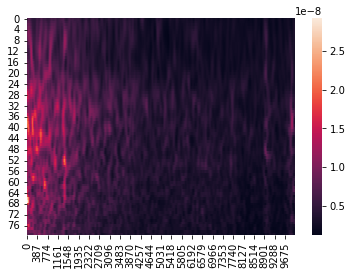

T18M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


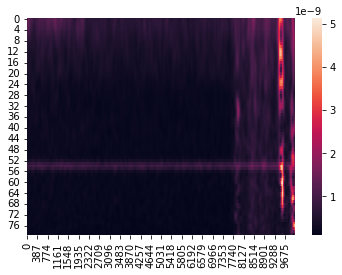

T25F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


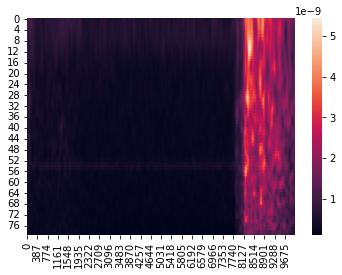

T18F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


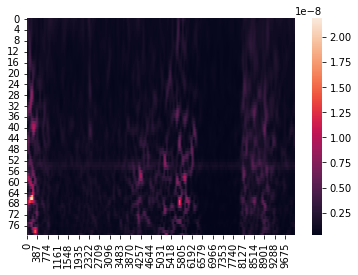

M8M2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


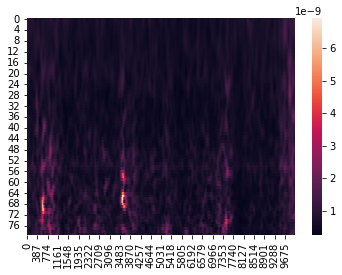

T23F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


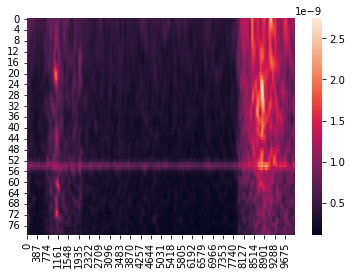

F12M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


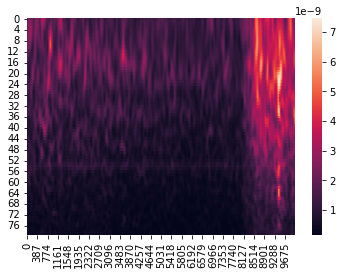

T23F2.bdf - Done!


In [6]:
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]

for participant in preproc_dict_all.keys():

    events = events_dict_all[participant]
    preproc = preproc_dict_all[participant]

    print('==================================================')
    print('REMOVING EVENTS ID NOT IN EEG FILE...')
    cur_event_id = copy.deepcopy(event_id)
    newevents_in_file = set(np.array(events_dict_all[participant])[:,2])
    keys_to_delete = []
    for e in cur_event_id.keys():
        if event_id[e] not in newevents_in_file:
            print('Event: {} ({}), not present.'.format(e, event_id[e]))
            keys_to_delete.append(e)
    for key in keys_to_delete:
        del cur_event_id[key]
    print('==================================================')   
        
    epochs = Epochs(preproc, events, event_id=cur_event_id, tmin=-3, tmax=20, baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')

    epochs_freq = epochs.copy().crop(tmin=0, tmax=15)#.pick_channels(['P7', 'P8', 'P3','C3', 'C4'])

    freqs = np.logspace(*np.log10([20, 100]), num=80)
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power, itc = tfr_morlet(epochs_freq, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, decim=3, n_jobs=1)
    
    ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='P7']
    freq_anal = power.data[ch_id[0], :, :]
    freq_anal.shape
    sns.heatmap(freq_anal[:,100:-100])
    plt.show()

    print(f'{participant} - Done!')

#times = epochs.copy().crop(tmin=tmin, tmax=tmax).times

REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
105 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 105 events and 47105 original time points ...
0 bad epochs dropped


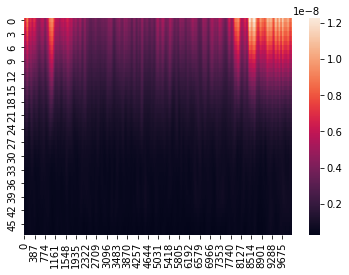

M8M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
75 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 75 events and 47105 original time points ...
0 bad epochs dropped


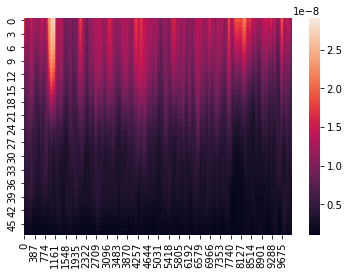

T16F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


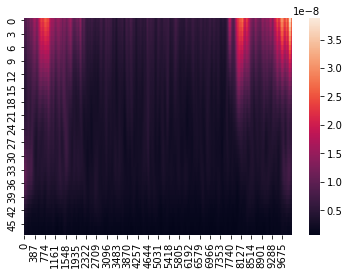

M22F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
83 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 83 events and 47105 original time points ...
0 bad epochs dropped


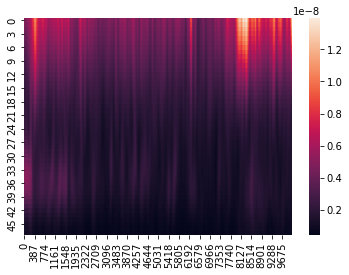

W17M2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


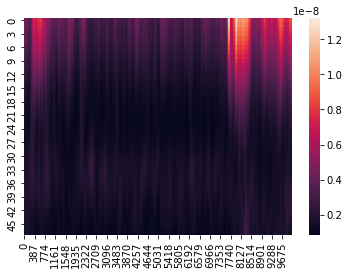

S20M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


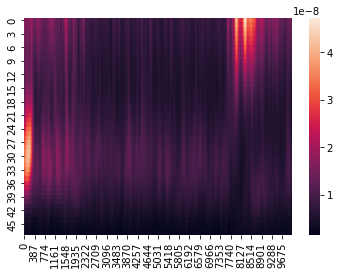

W10F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


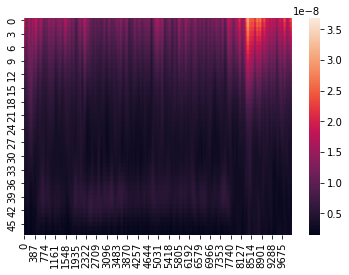

T11F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
94 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 94 events and 47105 original time points ...
0 bad epochs dropped


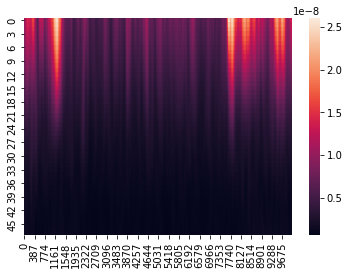

S21F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/left/bad (222), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


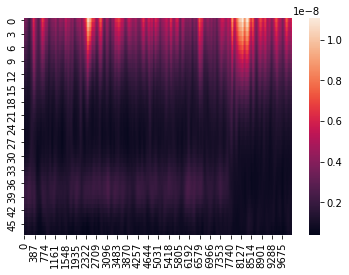

F19M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


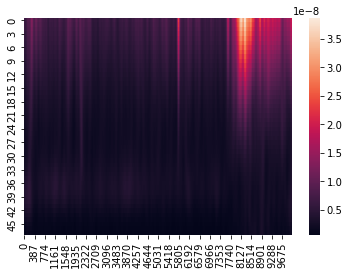

F12F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


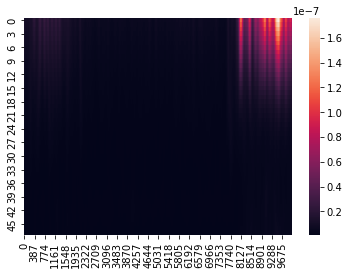

T9F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/right/bad (212), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


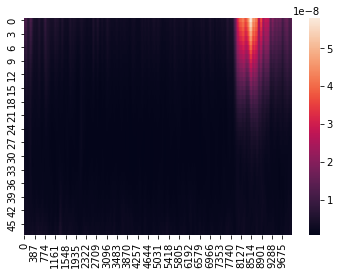

T18M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


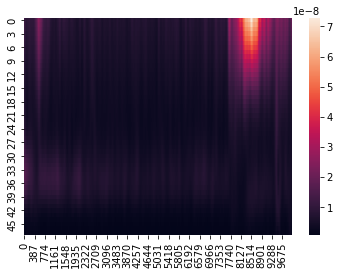

T25F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


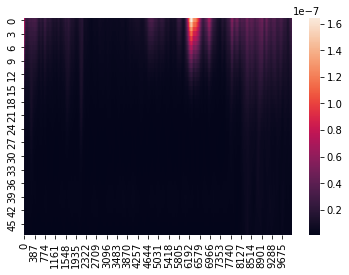

T18F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


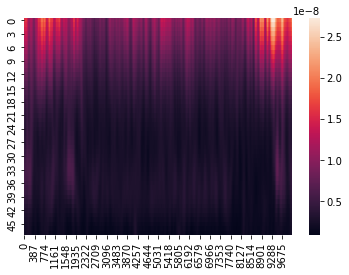

M8M2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


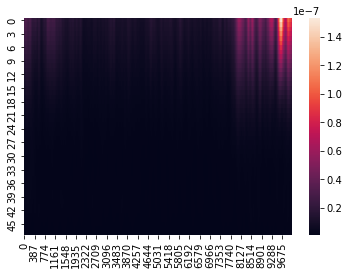

T23F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


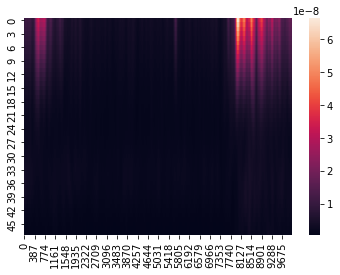

F12M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


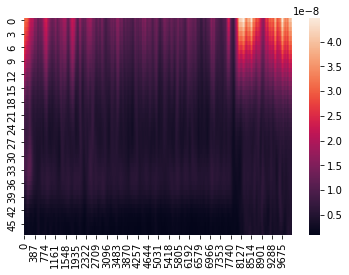

T23F2.bdf - Done!


In [7]:
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]

for participant in preproc_dict_all.keys():

    events = events_dict_all[participant]
    preproc = preproc_dict_all[participant]

    print('==================================================')
    print('REMOVING EVENTS ID NOT IN EEG FILE...')
    cur_event_id = copy.deepcopy(event_id)
    newevents_in_file = set(np.array(events_dict_all[participant])[:,2])
    keys_to_delete = []
    for e in cur_event_id.keys():
        if event_id[e] not in newevents_in_file:
            print('Event: {} ({}), not present.'.format(e, event_id[e]))
            keys_to_delete.append(e)
    for key in keys_to_delete:
        del cur_event_id[key]
    print('==================================================')   
        
    epochs = Epochs(preproc, events, event_id=cur_event_id, tmin=-3, tmax=20, baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')

    epochs_freq = epochs.copy().crop(tmin=0, tmax=15)#.pick_channels(['P7', 'P8', 'P3','C3', 'C4'])

    freqs = np.logspace(*np.log10([3, 15]), num=48)
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power, itc = tfr_morlet(epochs_freq, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, decim=3, n_jobs=1)
    
    ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='P7']
    freq_anal = power.data[ch_id[0], :, :]
    freq_anal.shape
    sns.heatmap(freq_anal[:,100:-100])
    plt.show()

    print(f'{participant} - Done!')

#times = epochs.copy().crop(tmin=tmin, tmax=tmax).times

REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
105 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 105 events and 47105 original time points ...
0 bad epochs dropped


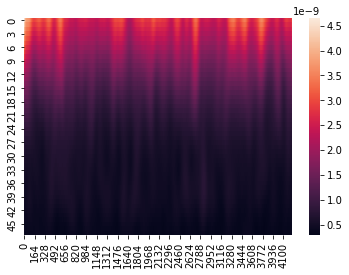

M8M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
75 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 75 events and 47105 original time points ...
0 bad epochs dropped


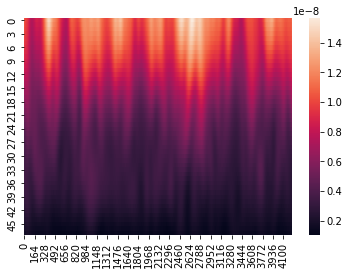

T16F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


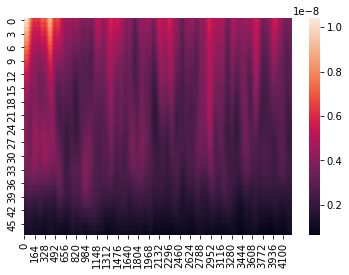

M22F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
83 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 83 events and 47105 original time points ...
0 bad epochs dropped


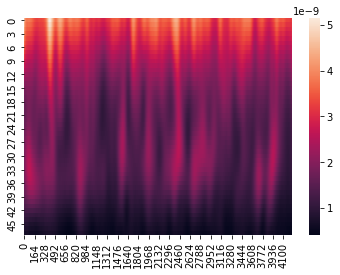

W17M2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


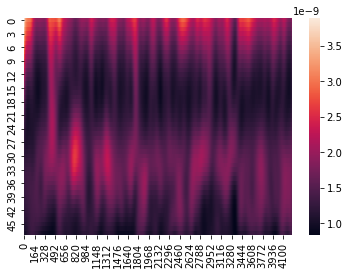

S20M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


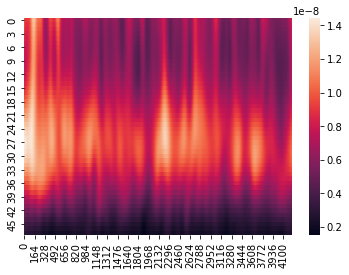

W10F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


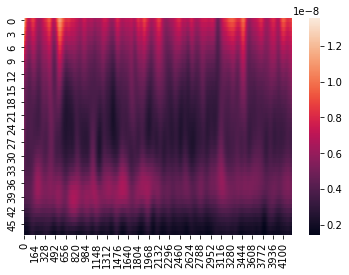

T11F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
94 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 94 events and 47105 original time points ...
0 bad epochs dropped


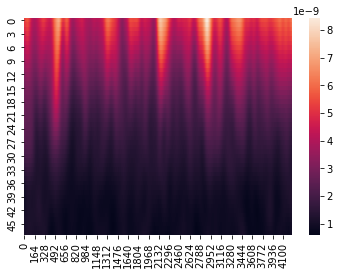

S21F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/left/bad (222), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


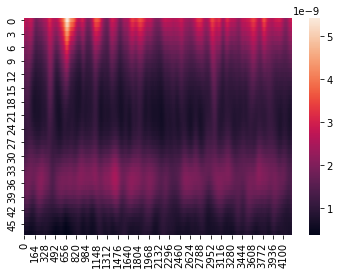

F19M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


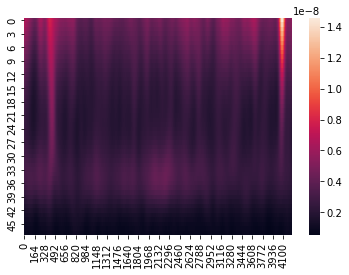

F12F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


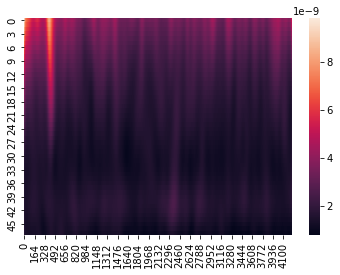

T9F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/right/bad (212), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


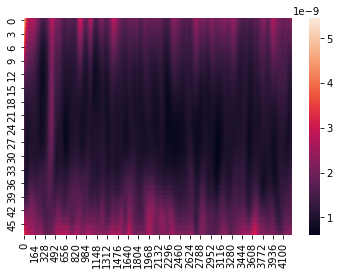

T18M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


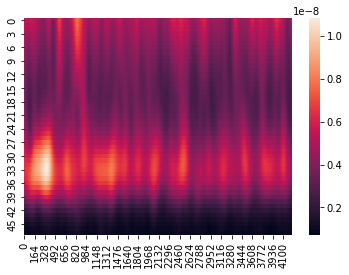

T25F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


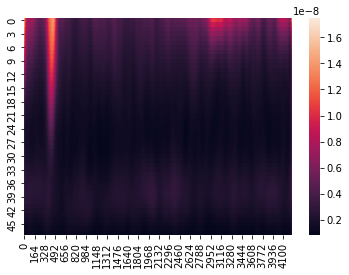

T18F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


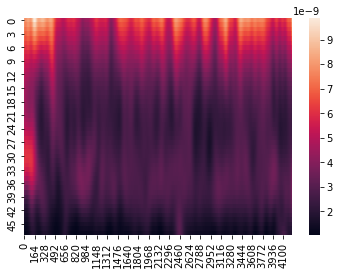

M8M2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


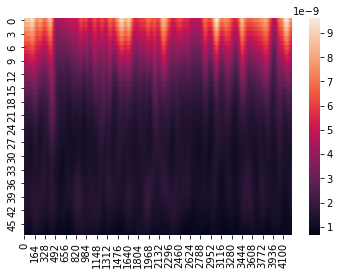

T23F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


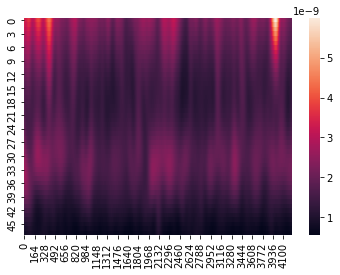

F12M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


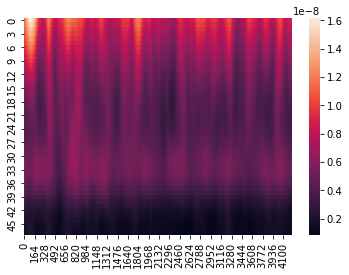

T23F2.bdf - Done!


In [8]:
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]

for participant in preproc_dict_all.keys():

    events = events_dict_all[participant]
    preproc = preproc_dict_all[participant]

    print('==================================================')
    print('REMOVING EVENTS ID NOT IN EEG FILE...')
    cur_event_id = copy.deepcopy(event_id)
    newevents_in_file = set(np.array(events_dict_all[participant])[:,2])
    keys_to_delete = []
    for e in cur_event_id.keys():
        if event_id[e] not in newevents_in_file:
            print('Event: {} ({}), not present.'.format(e, event_id[e]))
            keys_to_delete.append(e)
    for key in keys_to_delete:
        del cur_event_id[key]
    print('==================================================')   
        
    epochs = Epochs(preproc, events, event_id=cur_event_id, tmin=-3, tmax=20, baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')

    epochs_freq = epochs.copy().crop(tmin=2.5, tmax=9)#.pick_channels(['P7', 'P8', 'P3','C3', 'C4'])

    freqs = np.logspace(*np.log10([4, 15]), num=48)
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power, itc = tfr_morlet(epochs_freq, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, decim=3, n_jobs=1)
    
    ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='P7']
    freq_anal = power.data[ch_id[0], :, :]
    freq_anal.shape
    sns.heatmap(freq_anal[:,100:-100])
    plt.show()

    print(f'{participant} - Done!')

#times = epochs.copy().crop(tmin=tmin, tmax=tmax).times

REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
105 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 105 events and 47105 original time points ...
0 bad epochs dropped


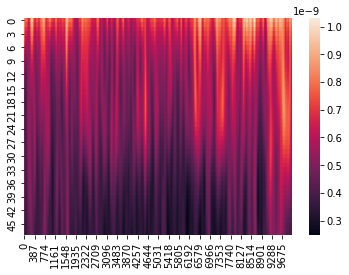

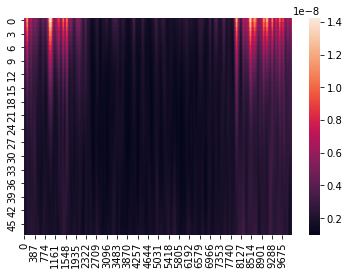

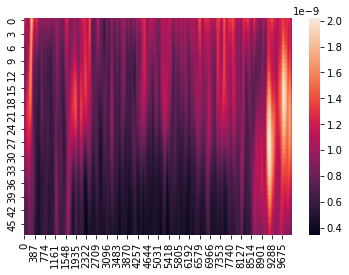

M8M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
75 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 75 events and 47105 original time points ...
0 bad epochs dropped


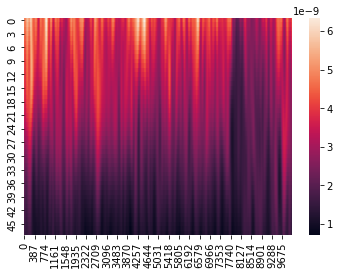

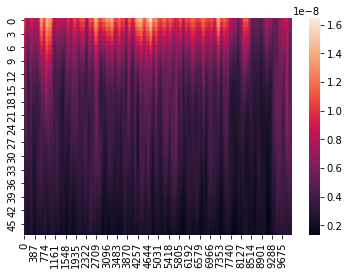

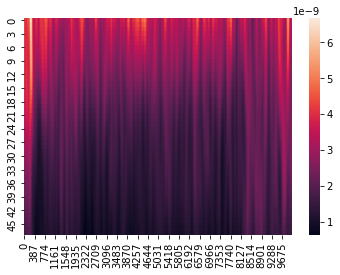

T16F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


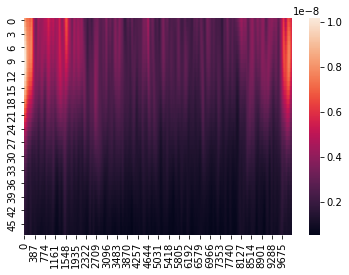

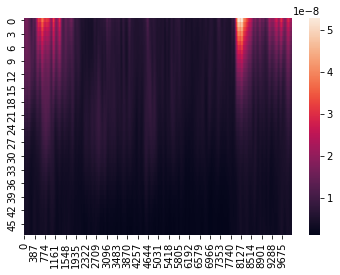

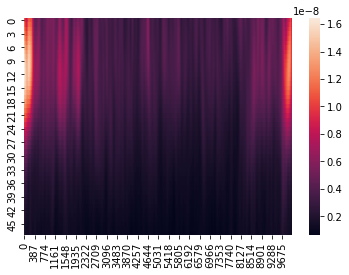

M22F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
83 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 83 events and 47105 original time points ...
0 bad epochs dropped


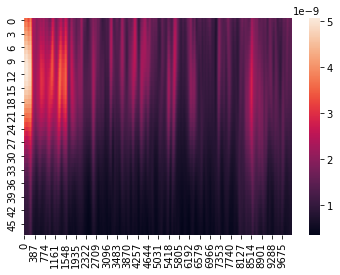

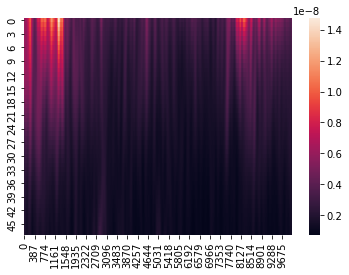

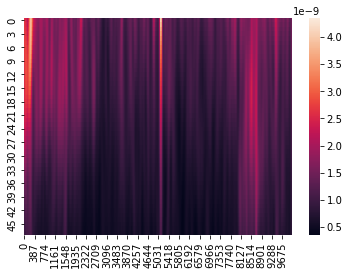

W17M2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


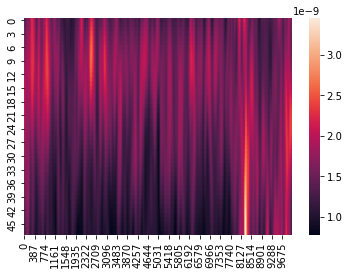

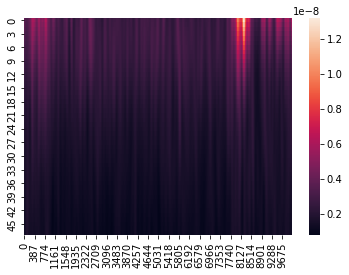

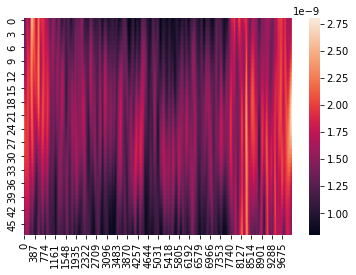

S20M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


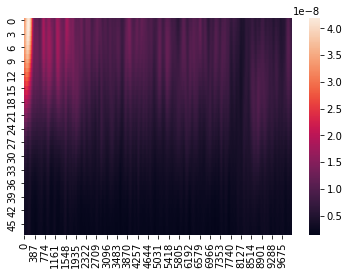

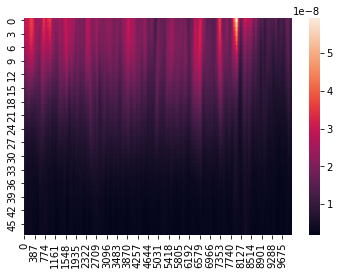

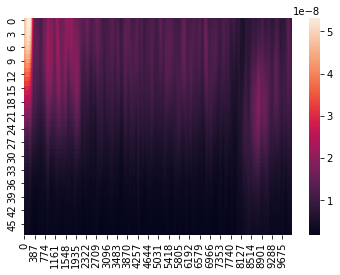

W10F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


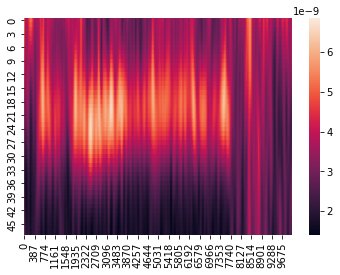

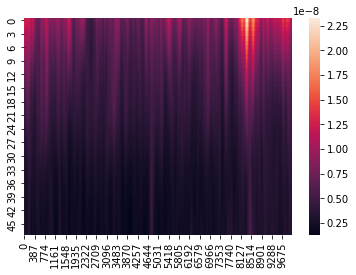

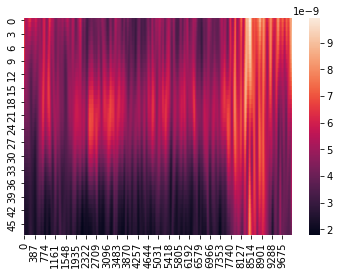

T11F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
94 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 94 events and 47105 original time points ...
0 bad epochs dropped


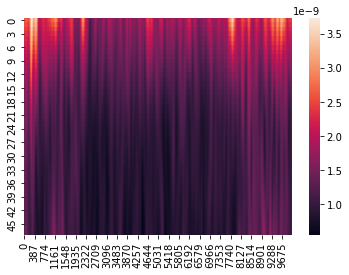

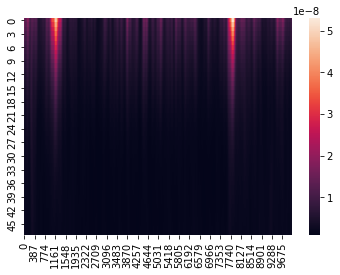

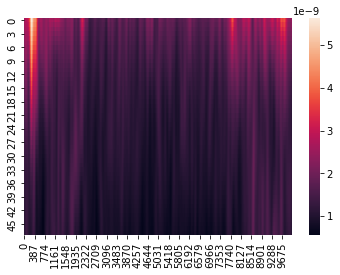

S21F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/left/bad (222), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


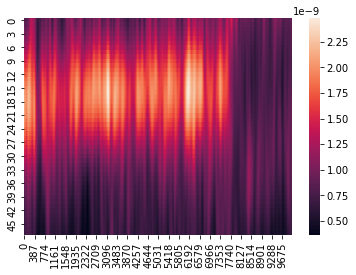

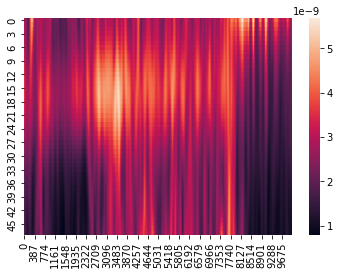

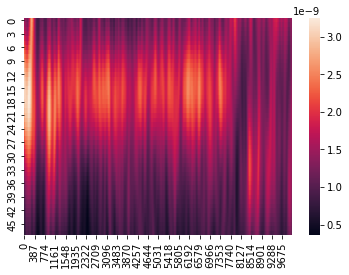

F19M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


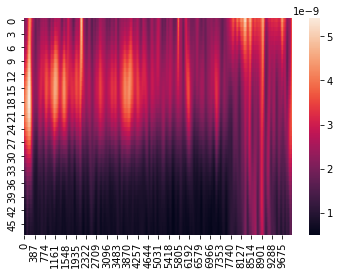

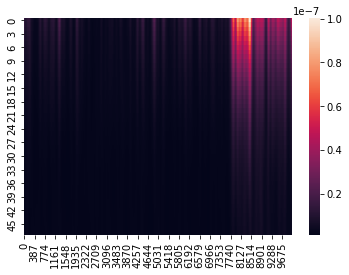

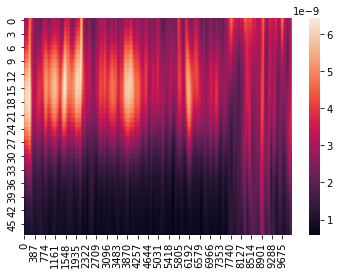

F12F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


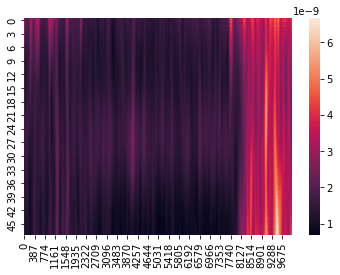

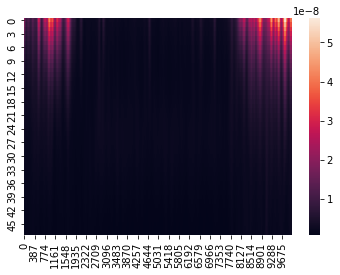

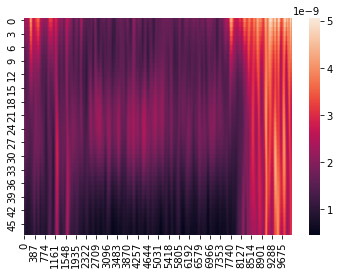

T9F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/right/bad (212), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


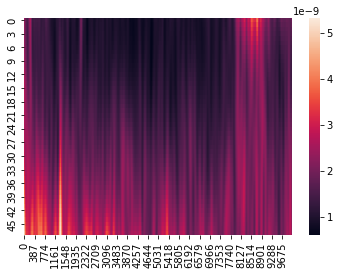

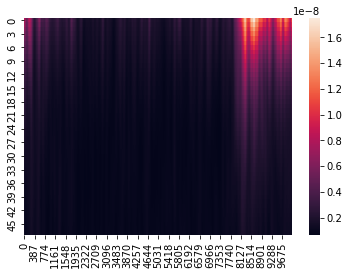

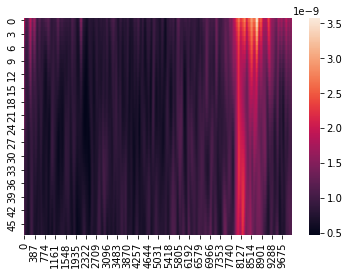

T18M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


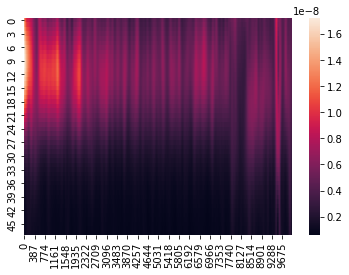

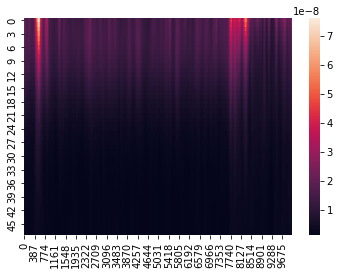

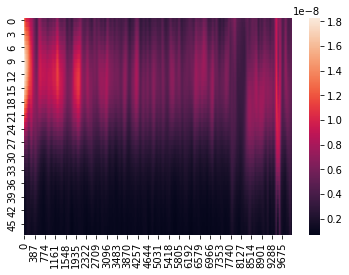

T25F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


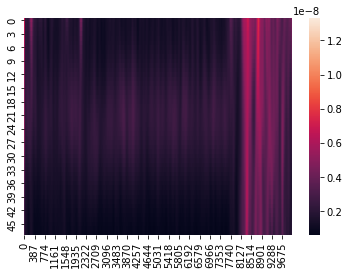

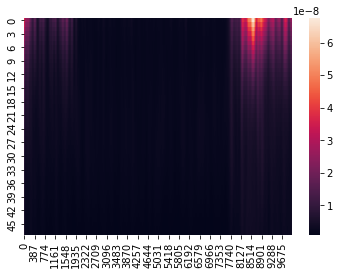

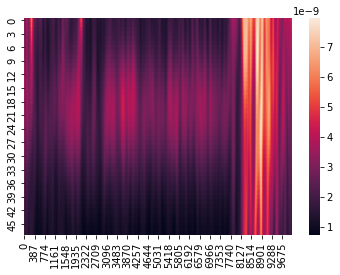

T18F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


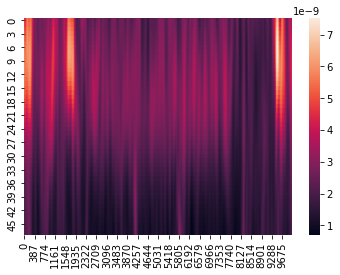

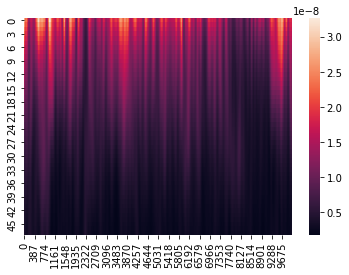

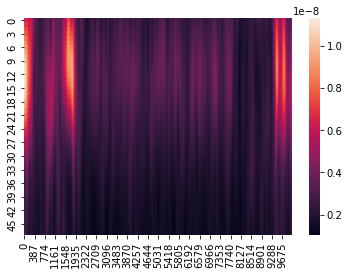

M8M2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


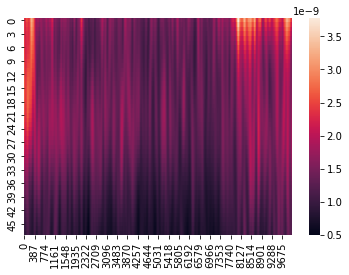

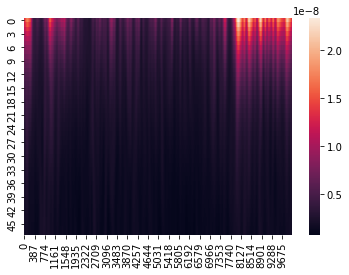

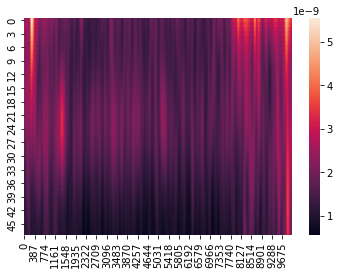

T23F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


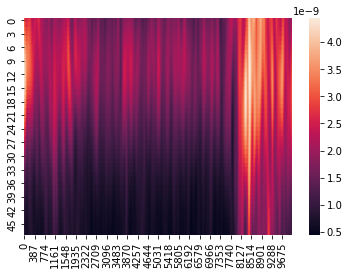

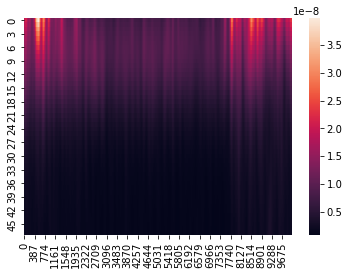

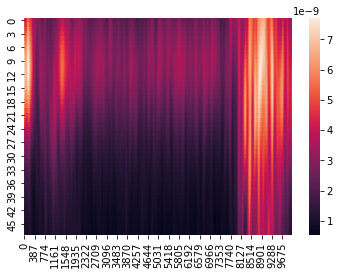

F12M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


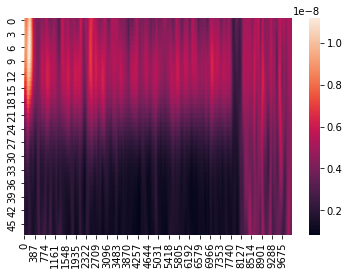

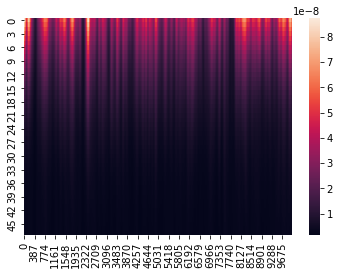

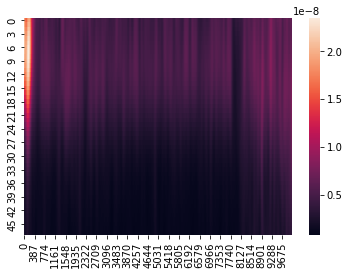

T23F2.bdf - Done!


In [9]:
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]

for participant in preproc_dict_all.keys():

    events = events_dict_all[participant]
    preproc = preproc_dict_all[participant]

    print('==================================================')
    print('REMOVING EVENTS ID NOT IN EEG FILE...')
    cur_event_id = copy.deepcopy(event_id)
    newevents_in_file = set(np.array(events_dict_all[participant])[:,2])
    keys_to_delete = []
    for e in cur_event_id.keys():
        if event_id[e] not in newevents_in_file:
            print('Event: {} ({}), not present.'.format(e, event_id[e]))
            keys_to_delete.append(e)
    for key in keys_to_delete:
        del cur_event_id[key]
    print('==================================================')   
        
    epochs = Epochs(preproc, events, event_id=cur_event_id, tmin=-3, tmax=20, baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')

    epochs_freq = epochs.copy().crop(tmin=0, tmax=15)#.pick_channels(['P7', 'P8', 'P3','C3', 'C4'])

    freqs = np.linspace(8, 16, 48)
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power, itc = tfr_morlet(epochs_freq, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, decim=3, n_jobs=1)
    
    ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='P7']
    freq_anal = power.data[ch_id[0], :, :]
    freq_anal.shape
    sns.heatmap(freq_anal[:,100:-100])
    plt.show()
    
    ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='AF3']
    freq_anal = power.data[ch_id[0], :, :]
    freq_anal.shape
    sns.heatmap(freq_anal[:,100:-100])
    plt.show()
    
    ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='O1']
    freq_anal = power.data[ch_id[0], :, :]
    freq_anal.shape
    sns.heatmap(freq_anal[:,100:-100])
    plt.show()

    print(f'{participant} - Done!')

#times = epochs.copy().crop(tmin=tmin, tmax=tmax).times

REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
105 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 105 events and 47105 original time points ...
0 bad epochs dropped


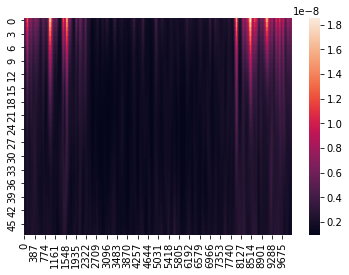

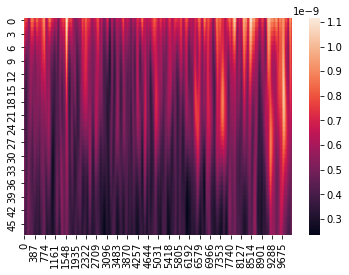

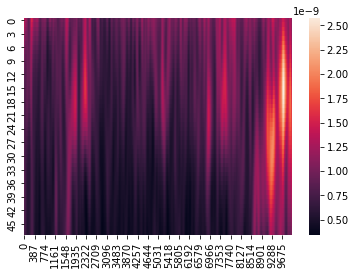

M8M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
75 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 75 events and 47105 original time points ...
0 bad epochs dropped


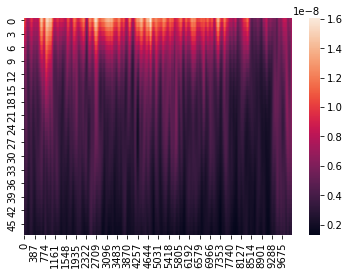

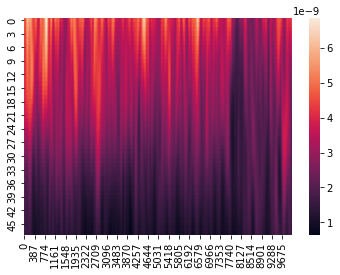

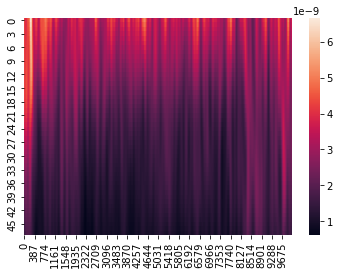

T16F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


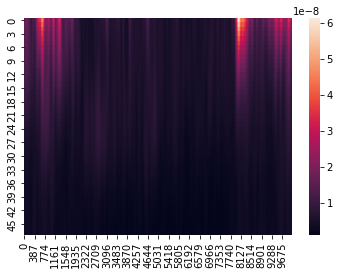

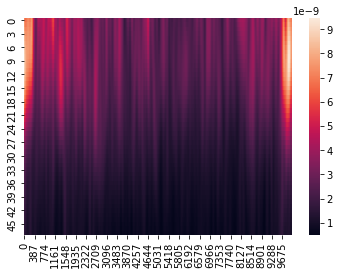

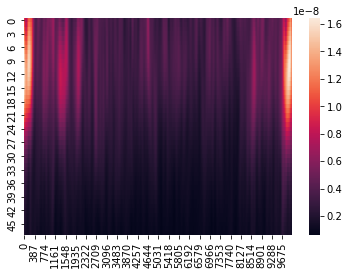

M22F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
83 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 83 events and 47105 original time points ...
0 bad epochs dropped


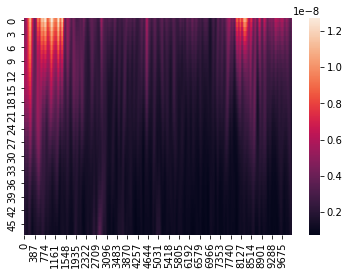

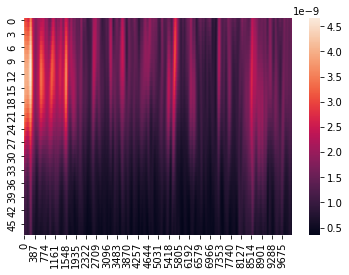

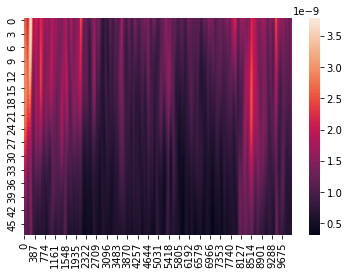

W17M2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


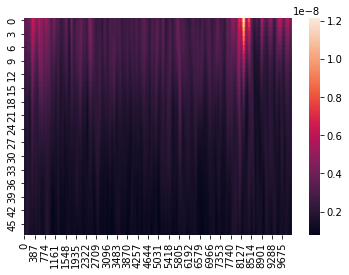

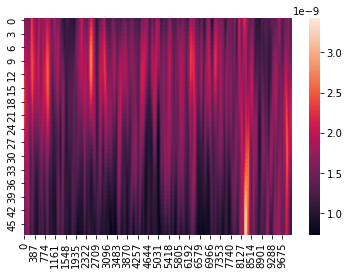

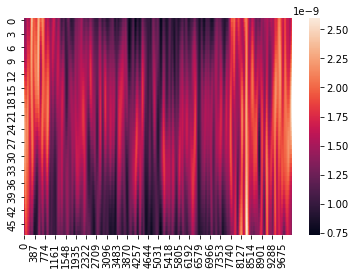

S20M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


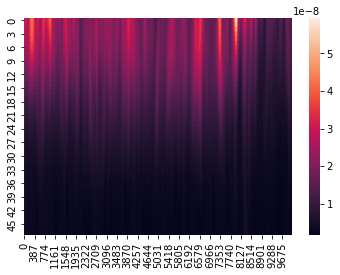

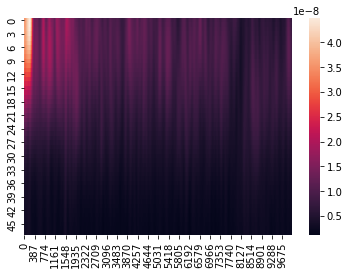

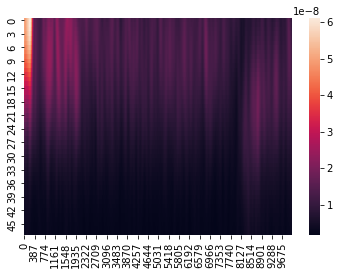

W10F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


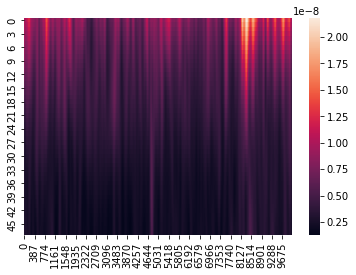

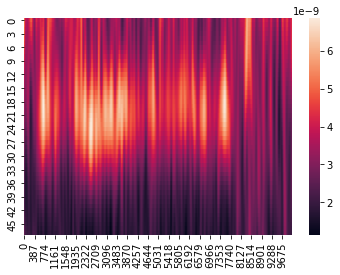

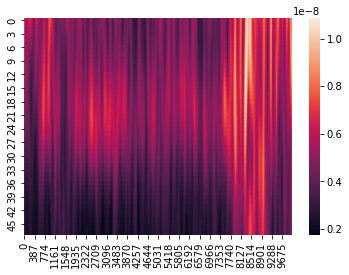

T11F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
94 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 94 events and 47105 original time points ...
0 bad epochs dropped


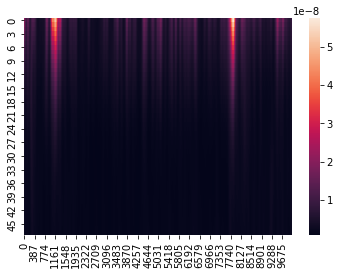

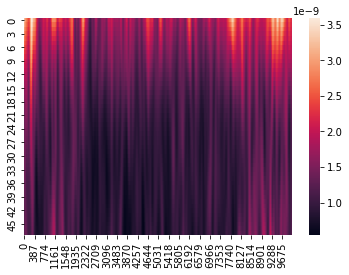

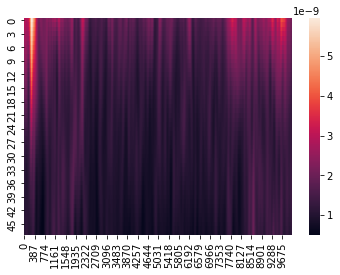

S21F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/left/bad (222), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


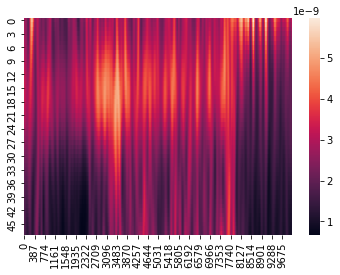

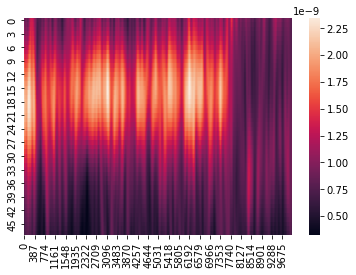

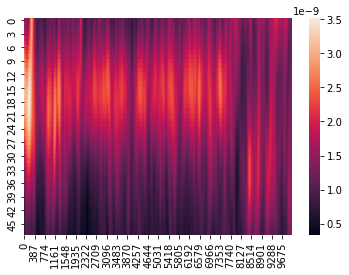

F19M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


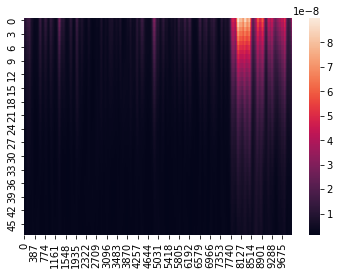

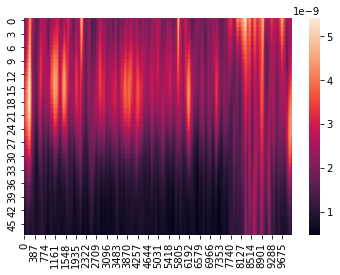

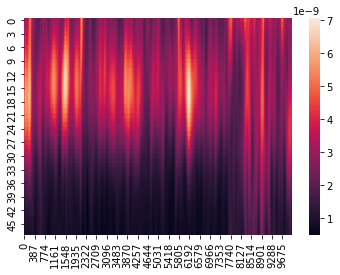

F12F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


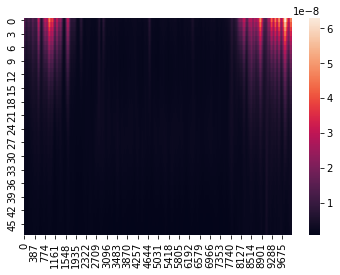

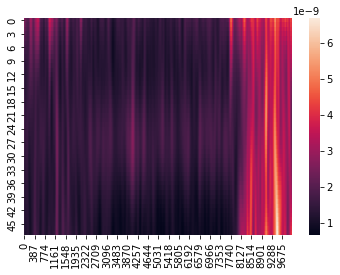

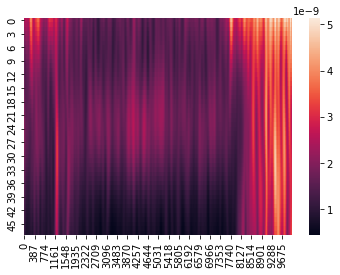

T9F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/right/bad (212), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


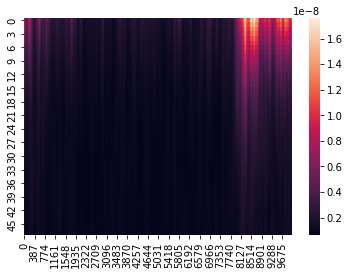

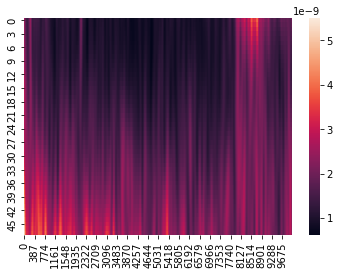

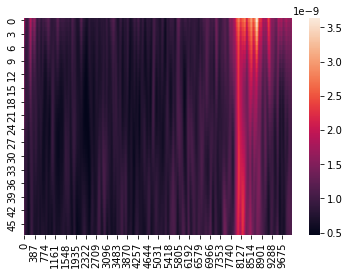

T18M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


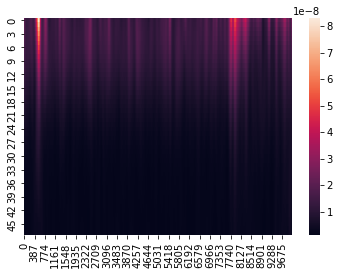

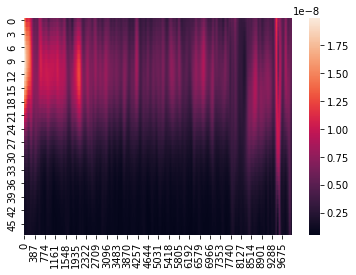

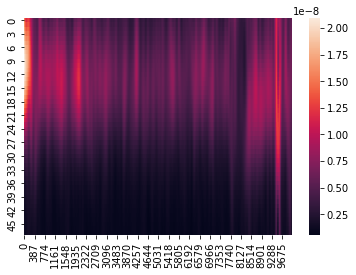

T25F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


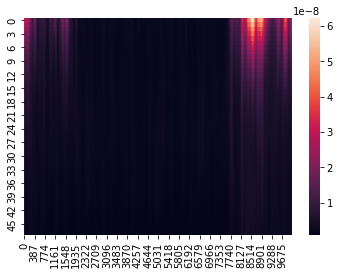

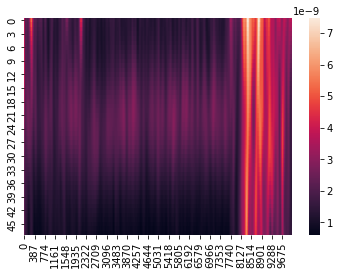

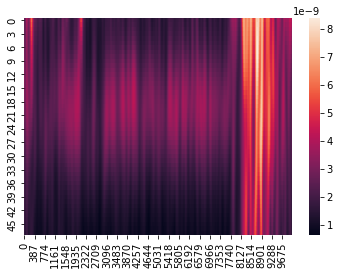

T18F2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


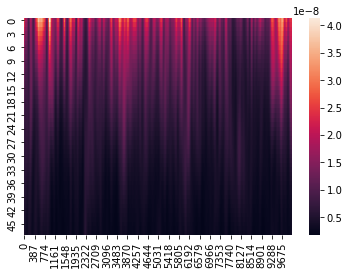

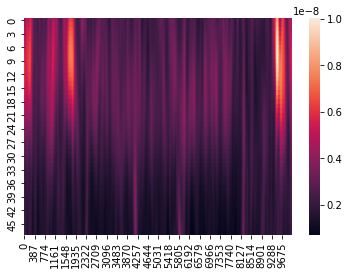

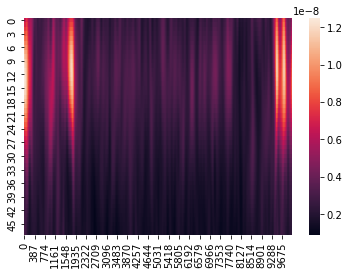

M8M2.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


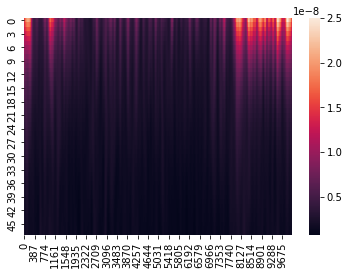

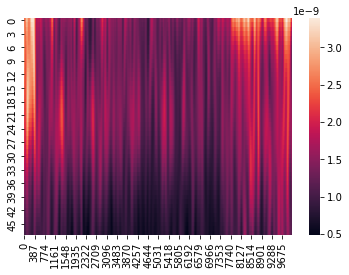

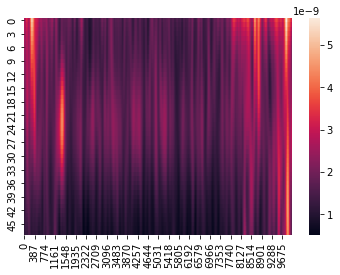

T23F1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


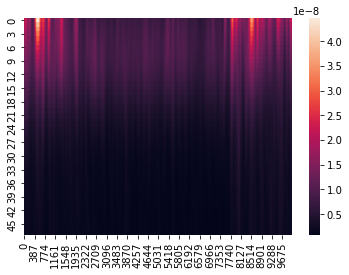

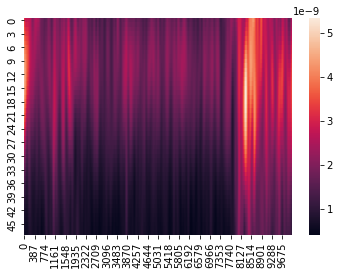

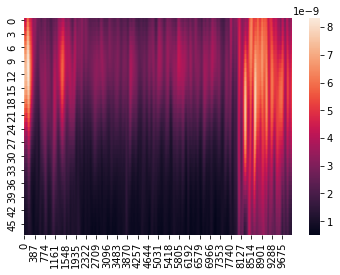

F12M1.bdf - Done!
REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/classicmod/bad (132), not present.
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


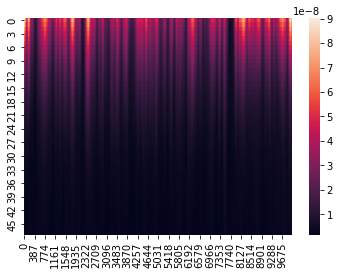

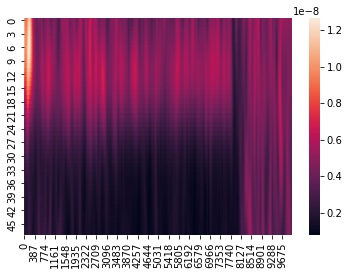

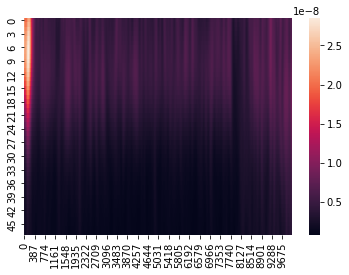

T23F2.bdf - Done!


In [10]:
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]

for participant in preproc_dict_all.keys():

    events = events_dict_all[participant]
    preproc = preproc_dict_all[participant]

    print('==================================================')
    print('REMOVING EVENTS ID NOT IN EEG FILE...')
    cur_event_id = copy.deepcopy(event_id)
    newevents_in_file = set(np.array(events_dict_all[participant])[:,2])
    keys_to_delete = []
    for e in cur_event_id.keys():
        if event_id[e] not in newevents_in_file:
            print('Event: {} ({}), not present.'.format(e, event_id[e]))
            keys_to_delete.append(e)
    for key in keys_to_delete:
        del cur_event_id[key]
    print('==================================================')   
        
    epochs = Epochs(preproc, events, event_id=cur_event_id, tmin=-3, tmax=20, baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')

    epochs_freq = epochs['good'].copy().crop(tmin=0, tmax=15)#.pick_channels(['P7', 'P8', 'P3','C3', 'C4'])

    freqs = np.linspace(8, 16, 48)
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power, itc = tfr_morlet(epochs_freq, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, decim=3, n_jobs=1)
    
    ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='AF3']
    freq_anal = power.data[ch_id[0], :, :]
    freq_anal.shape
    sns.heatmap(freq_anal[:,100:-100])
    plt.show()
    
    ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='P7']
    freq_anal = power.data[ch_id[0], :, :]
    freq_anal.shape
    sns.heatmap(freq_anal[:,100:-100])
    plt.show()
    
    ch_id = [i for i, ch in enumerate(power.info.ch_names) if ch =='O1']
    freq_anal = power.data[ch_id[0], :, :]
    freq_anal.shape
    sns.heatmap(freq_anal[:,100:-100])
    plt.show()

    print(f'{participant} - Done!')

#times = epochs.copy().crop(tmin=tmin, tmax=tmax).times